<a href="https://colab.research.google.com/github/TienTranTrung/ASL_Rerverse_translate/blob/master/notebooks/RNN_based_(GRU_LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Build dataset

In [ ]:
!pip install -q datasets sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

data = load_dataset("aslg_pc12")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/87710 [00:00<?, ? examples/s]

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['gloss', 'text'],
        num_rows: 87710
    })
})

In [ ]:
data['train'][0]

{'gloss': '\ufeffMEMBERSHIP PARLIAMENT SEE MINUTE\n',
 'text': '\ufeffmembership of parliament see minutes\n'}

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
SRC_LANGUAGE = 'text'
TGT_LANGUAGE = 'gloss'

token_transform = {}
vocab_transform = {}

token_transform[SRC_LANGUAGE] = get_tokenizer('basic_english')
token_transform[TGT_LANGUAGE] = get_tokenizer('basic_english')

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [ ]:
# def yield_tokens(data_iter, lang):
#     for data_sample in data_iter:
#         yield token_transformlang

def yield_tokens(data_iter, lang):
    for data_sample in data_iter:
        text = data_sample[lang]
        text = text.replace('\n', '')  # remove newline characters
        text = text.replace('\ufeff', '')  # remove unwanted unicode characters
        if lang == 'gloss':
            text = text.lower()  # make gloss lowercase
        yield token_transform[lang](data_sample[lang])

for lang in [SRC_LANGUAGE, TGT_LANGUAGE]:
    train_iter = data['train']

    # Create torchtext's Vocab object
    vocab_transform[lang] = build_vocab_from_iterator(
        yield_tokens(train_iter, lang),
        min_freq=1,
        specials=special_symbols,
        special_first=True
    )

    vocab_transform[lang].set_default_index(UNK_IDX)

In [ ]:
vocab_transform[SRC_LANGUAGE].get_itos()[:20]

['<unk>',
 '<pad>',
 '<bos>',
 '<eos>',
 '.',
 'the',
 ',',
 'of',
 'to',
 'is',
 'in',
 'and',
 'this',
 'a',
 'we',
 'that',
 'i',
 'for',
 'it',
 'be']

In [ ]:
vocab_transform[TGT_LANGUAGE].get_itos()[:20]

['<unk>',
 '<pad>',
 '<bos>',
 '<eos>',
 '.',
 'be',
 ',',
 'to',
 'x-we',
 'in',
 'and',
 'this',
 'that',
 'x-i',
 'have',
 'for',
 'x-it',
 'desc-not',
 'on',
 'will']

In [ ]:
len(vocab_transform[SRC_LANGUAGE]), len(vocab_transform[TGT_LANGUAGE])

(21022, 15855)

### DATA LOADER + Split dataset

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
MAX_LEN = 100

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for lang in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[lang] = sequential_transforms(
        token_transform[lang], # Tokenization
        vocab_transform[lang], # Numericalization
        tensor_transform # Add BOS/EOS and create tensor
    )

def truncate(sample):
    if sample.size(0) > MAX_LEN:
        return sample[MAX_LEN:, :]
    else:
        return sample

# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for sample in batch:
        src_sample, tgt_sample = sample[SRC_LANGUAGE], sample[TGT_LANGUAGE]
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample).to(dtype=torch.int64))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample).to(dtype=torch.int64))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    src_batch = truncate(src_batch)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = truncate(tgt_batch)
    return src_batch, tgt_batch

In [ ]:
from torch.utils.data import DataLoader, Subset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

BATCH_SIZE = 32

train_dataset = data['train']

# Create indices for the split
train_indices, temp_indices = train_test_split(list(range(len(train_dataset))), test_size=0.2, random_state=42)
valid_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

# Create PyTorch Datasets
train_data = Subset(train_dataset, train_indices)
valid_data = Subset(train_dataset, valid_indices)
test_data = Subset(train_dataset, test_indices)

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

valid_dataloader = DataLoader(
    valid_data,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

In [ ]:
print(f"Size of training data: {len(train_data)}")
print(f"Size of validation data: {len(valid_data)}")
print(f"Size of test data: {len(test_data)}")

Size of training data: 70168
Size of validation data: 8771
Size of test data: 8771


In [ ]:
src_ids, tgt_ids = next(iter(train_dataloader))
src_ids.shape, tgt_ids.shape

(torch.Size([32, 23]), torch.Size([32, 21]))

#2. Model Build

## Template

In [ ]:
class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderGRU, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [ ]:
input_size = len(vocab_transform[SRC_LANGUAGE])
hidden_size = 256

encoder = EncoderGRU(input_size, hidden_size)

In [ ]:
encoder_output, encoder_hidden = encoder(src_ids)
encoder_output.shape, encoder_hidden.shape

(torch.Size([32, 23, 256]), torch.Size([1, 32, 256]))

In [ ]:
class DecoderGRU(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderGRU, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output = self.embedding(input)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, BOS_IDX):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.BOS_IDX = BOS_IDX

    def forward(self, src_ids, tgt_ids):
        batch_size = tgt_ids.size(0)
        seq_len = tgt_ids.size(1)

        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=self.device).fill_(self.BOS_IDX)
        encoder_output, decoder_hidden = self.encoder(src_ids)
        decoder_outputs = []

        for i in range(seq_len):
            decoder_output, decoder_hidden  = self.decoder(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            # Teacher forcing: Feed the target as the next input
            decoder_input = tgt_ids[:, i].unsqueeze(1) # Teacher forcing

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return decoder_outputs, decoder_hidden

In [ ]:
input_size = len(vocab_transform[SRC_LANGUAGE])
output_size = len(vocab_transform[TGT_LANGUAGE])
hidden_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = EncoderGRU(input_size, hidden_size)
decoder = DecoderGRU(hidden_size, output_size)
model = Seq2Seq(encoder, decoder, device, EOS_IDX)
model.to(device)

Seq2Seq(
  (encoder): EncoderGRU(
    (embedding): Embedding(21022, 256)
    (gru): GRU(256, 256, batch_first=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): DecoderGRU(
    (embedding): Embedding(15855, 256)
    (gru): GRU(256, 256, batch_first=True)
    (out): Linear(in_features=256, out_features=15855, bias=True)
  )
)

In [ ]:
tgt_input = tgt_ids[:, :-1]
tgt_output = tgt_ids[:, 1:]
decoder_outputs, decoder_hidden = model(src_ids.to(device), tgt_input.to(device))

In [ ]:
decoder_outputs.shape, decoder_hidden.shape

(torch.Size([32, 20, 15855]), torch.Size([1, 32, 256]))

In [ ]:
tgt_output.shape

torch.Size([32, 20])

## Attention Mechanism

In [ ]:
# General attention mechanism
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.shape[1]
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        attn_energies = self.score(h, encoder_outputs)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

    def score(self, hidden, encoder_outputs):
        # Repeat hidden state across the sequence length dimension
        hidden = hidden.repeat(1, encoder_outputs.size(1), 1)
        energy = F.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(1, 2)
        v = self.v.repeat(encoder_outputs.data.shape[0], 1).unsqueeze(1)
        energy = torch.bmm(v, energy)
        return energy.squeeze(1)

In [ ]:
class LuongAttention(nn.Module):
    def __init__(self, hidden_size):
        super(LuongAttention, self).__init__()
        self.hidden_size = hidden_size

    def forward(self, decoder_hidden, encoder_outputs):
        # Calculate alignment scores
        alignment_scores = torch.bmm(decoder_hidden, encoder_outputs.transpose(1, 2))
        # Normalize alignment scores
        attn_weights = F.softmax(alignment_scores.view(-1, encoder_outputs.size(1)), dim=1).view(-1, 1, encoder_outputs.size(1))
        # Calculate context vector
        context_vector = torch.bmm(attn_weights, encoder_outputs)
        return context_vector, attn_weights

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.hidden_size = hidden_size
        self.key_layer = nn.Linear(hidden_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(hidden_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, decoder_hidden, encoder_outputs):
        # Calculate alignment scores
        key = self.key_layer(encoder_outputs)
        query = self.query_layer(decoder_hidden)
        alignment_scores = self.energy_layer(torch.tanh(key + query)).squeeze(2)
        # Normalize alignment scores
        attn_weights = F.softmax(alignment_scores, dim=1).unsqueeze(1)
        # Calculate context vector
        context_vector = torch.bmm(attn_weights, encoder_outputs)
        return context_vector, attn_weights

## 1D CNN + BiLSTM + Attention Mechanism

In [ ]:
class Encoder_CNN_BiLSTM_Att(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(Encoder_CNN_BiLSTM_Att, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.conv1 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(hidden_size, hidden_size, bidirectional=True, batch_first=True)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        conv_out = F.relu(self.conv1(embedded.transpose(1,2)))
        output, (hidden, cell) = self.lstm(conv_out.transpose(1,2))
        return output, (hidden, cell)

class Decoder_CNN_BiLSTM_Att(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder_CNN_BiLSTM_Att, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)  # change hidden_size * 2 to hidden_size
        self.attn = BahdanauAttention(hidden_size * 2, output_size)

    def forward(self, input, hidden, cell, encoder_outputs):
        output = self.embedding(input)
        attn_weights = self.attn(output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs)
        output = torch.cat((output, context), 2)
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        output = self.out(output.view(-1, self.hidden_size))  # change self.hidden_size * 2 to self.hidden_size
        return output, (hidden, cell), attn_weights


## 1DCNN + BiGRU + Attention Mechanism

In [ ]:
class Encoder_CNN_BiGRU_Att(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(Encoder_CNN_BiGRU_Att, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.conv1 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.gru = nn.GRU(hidden_size, hidden_size, bidirectional=True, batch_first=True)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        conv_out = F.relu(self.conv1(embedded.transpose(1,2)))
        output, hidden = self.gru(conv_out.transpose(1,2))
        return output, hidden
class Decoder_CNN_BiGRU_Att(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder_CNN_BiGRU_Att, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.attn = Attention(hidden_size)

    def forward(self, input, hidden, encoder_outputs):
        output = self.embedding(input)
        attn_weights = self.attn(output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs)
        output = torch.cat((output, context), 2)
        output, hidden = self.gru(output, hidden)
        output = self.out(output.view(-1, self.hidden_size))
        return output, hidden, attn_weights

# Transformer

# 3. Trainer

In [ ]:
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

def train_epoch(model, optimizer, criterion, train_dataloader, device):
    model.train()
    losses = []

    for idx, (src_ids, tgt_ids) in enumerate(train_dataloader):
        src_ids = src_ids.to(device)
        tgt_ids = tgt_ids.to(device)

        tgt_input = tgt_ids[:, :-1]
        tgt_output = tgt_ids[:, 1:]

        optimizer.zero_grad()
        decoder_outputs, decoder_hidden = model(src_ids, tgt_input)

        loss = criterion(
            decoder_outputs.reshape(-1, decoder_outputs.shape[-1]),
            tgt_output.reshape(-1))
        loss.backward()

        optimizer.step()
        losses.append(loss.item())

    return sum(losses) / len(losses)

def evaluate(model, data_loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for idx, (src_ids, tgt_ids) in enumerate(data_loader):
            src_ids = src_ids.to(device)
            tgt_ids = tgt_ids.to(device)
            tgt_input = tgt_ids[:, :-1]
            tgt_output = tgt_ids[:, 1:]

            decoder_outputs, decoder_hidden = model(src_ids, tgt_input)
            loss = criterion(
                decoder_outputs.reshape(-1, decoder_outputs.shape[-1]),
                tgt_output.reshape(-1)
            )
            losses.append(loss.item())
    return sum(losses) / len(losses)

In [ ]:
# def train(model, train_dataloader, valid_dataloader, optimizer, criterion, device, epochs):
#     for epoch in range(1, epochs+1):
#         start_time = time.time()
#         train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device)
#         valid_loss = evaluate(model, valid_dataloader, criterion, device)
#         end_time = time.time()
#         print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {valid_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
def train(model, train_dataloader, valid_dataloader, optimizer, criterion, device, epochs, patience=5, save_path='model.pt'):
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience)
    best_loss = float('inf')
    no_improve_epoch = 0

    train_losses = []
    valid_losses = []

    for epoch in range(1, epochs+1):
        start_time = time.time()
        train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device)
        valid_loss = evaluate(model, valid_dataloader, criterion, device)
        end_time = time.time()

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if valid_loss < best_loss:
            best_loss = valid_loss
            no_improve_epoch = 0
            # Save the model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, save_path)
        else:
            no_improve_epoch += 1

        if no_improve_epoch == patience:
            print(f'Early stopping at epoch {epoch}, best loss: {best_loss}')
            break

        scheduler.step(valid_loss)

        print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {valid_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()

Epoch: 1, Train loss: 4.547, Val loss: 3.838, Epoch time = 60.498s
Epoch: 2, Train loss: 3.423, Val loss: 3.327, Epoch time = 62.866s
Epoch: 3, Train loss: 2.905, Val loss: 3.090, Epoch time = 60.594s
Epoch: 4, Train loss: 2.549, Val loss: 2.958, Epoch time = 59.242s
Epoch: 5, Train loss: 2.279, Val loss: 2.892, Epoch time = 59.805s
Epoch: 6, Train loss: 2.069, Val loss: 2.864, Epoch time = 59.315s
Epoch: 7, Train loss: 1.896, Val loss: 2.837, Epoch time = 59.680s
Epoch: 8, Train loss: 1.753, Val loss: 2.831, Epoch time = 59.599s
Epoch: 9, Train loss: 1.635, Val loss: 2.847, Epoch time = 59.413s
Epoch: 10, Train loss: 1.537, Val loss: 2.854, Epoch time = 59.609s
Epoch: 11, Train loss: 1.447, Val loss: 2.860, Epoch time = 59.471s
Epoch: 12, Train loss: 1.375, Val loss: 2.916, Epoch time = 59.892s
Early stopping at epoch 13, best loss: 2.830533838272095


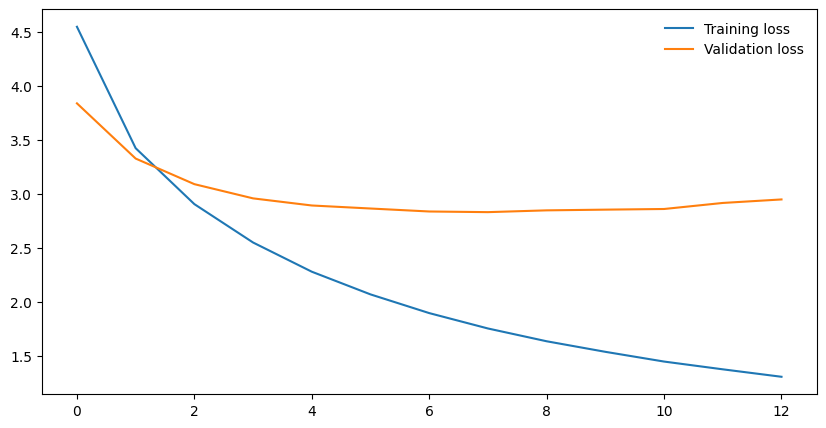

In [ ]:
import torch.optim as optim

input_size = len(vocab_transform[SRC_LANGUAGE])
output_size = len(vocab_transform[TGT_LANGUAGE])
hidden_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = EncoderGRU(input_size, hidden_size)
decoder = DecoderGRU(hidden_size, output_size)
model = Seq2Seq(encoder, decoder, device, EOS_IDX)
model.to(device)

epochs = 100
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters())
train(model, train_dataloader, valid_dataloader, optimizer, criterion, device, epochs)

### Load model from checkpoint

In [ ]:
checkpoint = torch.load('model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()  # For inference
# - OR -
model.train()  # For further training

### 1DCNN+BiLSTM+ATT

In [ ]:
class Seq2Seq_V2(nn.Module):
    def __init__(self, encoder, decoder, device, BOS_IDX):
        super(Seq2Seq_V2, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.BOS_IDX = BOS_IDX

    def forward(self, src_ids, tgt_ids):
        batch_size = tgt_ids.size(0)
        seq_len = tgt_ids.size(1)

        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=self.device).fill_(self.BOS_IDX)
        encoder_outputs, (hidden, cell) = self.encoder(src_ids)
        decoder_outputs = []

        for i in range(seq_len):
            decoder_output, (hidden, cell), _ = self.decoder(decoder_input, hidden, cell, encoder_outputs)
            decoder_outputs.append(decoder_output)

            # Teacher forcing: Feed the target as the next input
            decoder_input = tgt_ids[:, i].unsqueeze(1) # Teacher forcing

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return decoder_outputs, (hidden, cell)


In [ ]:
input_size = len(vocab_transform[SRC_LANGUAGE])
output_size = len(vocab_transform[TGT_LANGUAGE])
hidden_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder_CNN_BiLSTM_Att(input_size, hidden_size)
decoder = Decoder_CNN_BiLSTM_Att(hidden_size, output_size)
model = Seq2Seq_V2(encoder, decoder, device, EOS_IDX)
model.to(device)

Seq2Seq_V2(
  (encoder): Encoder_CNN_BiLSTM_Att(
    (embedding): Embedding(21022, 256)
    (dropout): Dropout(p=0.1, inplace=False)
    (conv1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder_CNN_BiLSTM_Att(
    (embedding): Embedding(15855, 256)
    (lstm): LSTM(512, 256, batch_first=True)
    (out): Linear(in_features=256, out_features=15855, bias=True)
    (attn): BahdanauAttention(
      (key_layer): Linear(in_features=15855, out_features=512, bias=False)
      (query_layer): Linear(in_features=512, out_features=512, bias=False)
      (energy_layer): Linear(in_features=512, out_features=1, bias=False)
    )
  )
)

In [ ]:
tgt_input = tgt_ids[:, :-1]
tgt_output = tgt_ids[:, 1:]
decoder_outputs, decoder_hidden = model(src_ids.to(device), tgt_input.to(device))

In [ ]:
decoder_outputs.shape, decoder_hidden.shape

(torch.Size([32, 20, 15855]), torch.Size([1, 32, 256]))

In [ ]:
tgt_output.shape

torch.Size([32, 20])

# Inference (Testing)

### 1. RNN/GRU Inference


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def greedy_decode_rnn(model, src, max_len, start_symbol):
    src = src.to(device)
    memory, hidden = model.encoder(src)

    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        out, hidden = model.decoder(ys, hidden)
        prob = model.decoder.out(hidden.squeeze(0))
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break
    return ys


def translate_rnn(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(1, -1)
    num_tokens = src.shape[1]
    tgt_tokens = greedy_decode_rnn(
        model,  src, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(
        vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")


In [ ]:
translate_rnn(model, "how are you")

' be ? '

In [ ]:
from tqdm import tqdm
import sacrebleu

pred_sentences, tgt_sentences = [], []
for sample in tqdm(test_data):
    src_sentence = sample[SRC_LANGUAGE]
    tgt_sentence = sample[TGT_LANGUAGE]

    pred_sentence = translate_rnn(model, src_sentence)
    pred_sentences.append(pred_sentence)

    tgt_sentences.append(tgt_sentence)

bleu_score = sacrebleu.corpus_bleu(pred_sentences, [tgt_sentences], force=True)
bleu_score

100%|██████████| 8771/8771 [00:47<00:00, 184.56it/s]


BLEU = 0.01 12.5/0.0/0.0/0.0 (BP = 0.356 ratio = 0.492 hyp_len = 50875 ref_len = 103405)

### 2. Inference 1DCNN+BiLSTM

### 3. Inference Transformer

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(1))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word[-1].item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(1, -1)
    num_tokens = src.shape[1]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(
        vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")